In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

warnings.simplefilter(action='ignore', category=FutureWarning)

Top correlated features:
F29     0.286175
F38     0.259473
F34     0.246612
F33     0.233905
F55     0.230507
F73     0.203699
F105    0.201505
F79     0.198132
F76     0.193717
F72     0.191766
Name: Rugosity, dtype: float64

Least correlated features:
F54    -0.155792
F50    -0.157094
F30    -0.188157
F60    -0.197608
F81    -0.203739
F39    -0.208002
F102   -0.241763
F5     -0.258784
F57    -0.266042
F27    -0.318926
Name: Rugosity, dtype: float64


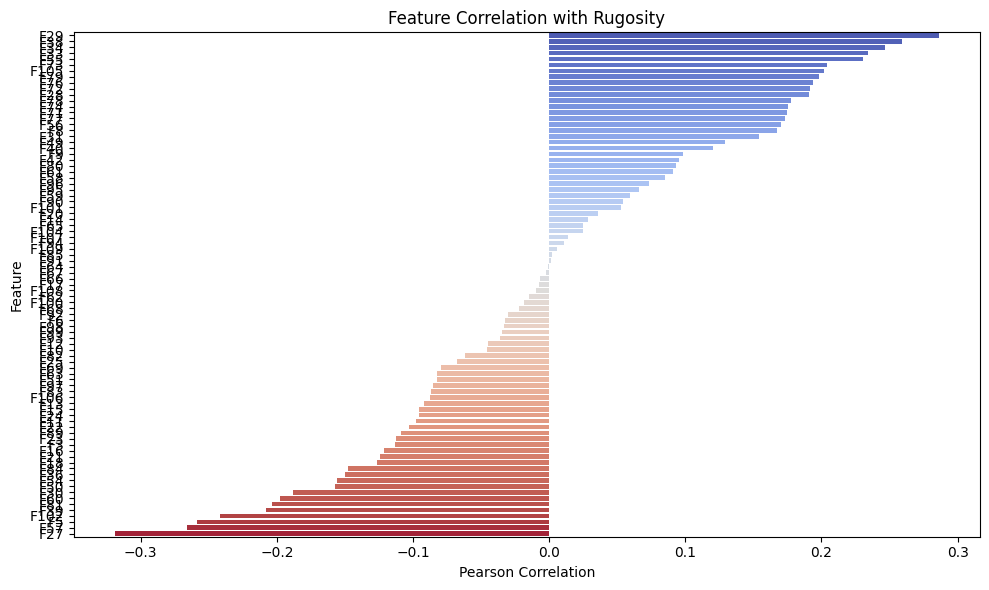

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your Excel file
file_path = r"C:\Users\boonk\Documents laptop\URECA Desktop\Data analysis\PlayGround\playground 2.0\Aesthetic_Scores_FFNN_Regularized.xlsx"
df = pd.read_excel(file_path)

# Dynamically get all feature columns starting with 'F'
feature_cols = [col for col in df.columns if col.startswith('F')]

# Select only features and target
X = df[feature_cols]
y = df['Rugosity']

# Combine into one DataFrame for correlation analysis
data_corr = X.copy()
data_corr['Rugosity'] = y

# Compute correlation matrix (only features vs Rugosity)
correlations = data_corr.corr()['Rugosity'].drop('Rugosity').sort_values(ascending=False)

# Print top and bottom correlated features
print("Top correlated features:")
print(correlations.head(10))

print("\nLeast correlated features:")
print(correlations.tail(10))

# Plot correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Feature Correlation with Rugosity')
plt.xlabel('Pearson Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [3]:
# Re-import necessary libraries after code environment reset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Reload the dataset
file_path = r"C:\Users\boonk\Documents laptop\URECA Desktop\Data analysis\PlayGround\playground 2.0\Aesthetic_Scores_FFNN_Regularized.xlsx"
df = pd.read_excel(file_path)

# Extract feature columns and target
feature_cols = [col for col in df.columns if col.startswith('F')]
X = df[feature_cols]
y = df['Rugosity']

# Normalize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 1: Refit XGBoost model on full data to extract built-in feature importances
xgb_full = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_full.fit(X_scaled, y)

# Step 2: Get top 20 features by built-in XGBoost importance
importances = xgb_full.feature_importances_
top_20_indices_xgb = importances.argsort()[-20:][::-1]
top_20_features_xgb = [feature_cols[i] for i in top_20_indices_xgb]

# Step 3: Prepare data with top 20 features only
X_top20 = df[top_20_features_xgb]
X_top20_scaled = scaler.fit_transform(X_top20)
X_train20, X_test20, y_train20, y_test20 = train_test_split(X_top20_scaled, y, test_size=0.2, random_state=42)

# Step 4: Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

# Step 5: Run GridSearchCV
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='r2', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train20, y_train20)

# Step 6: Evaluate best model
best_model = grid_search.best_estimator_
y_pred20 = best_model.predict(X_test20)
r2_20 = r2_score(y_test20, y_pred20)
mse_20 = mean_squared_error(y_test20, y_pred20)

(top_20_features_xgb, grid_search.best_params_, r2_20, mse_20)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


(['F55',
  'F27',
  'F36',
  'F56',
  'F16',
  'F21',
  'F17',
  'F39',
  'F90',
  'F18',
  'F34',
  'F38',
  'F29',
  'F31',
  'F13',
  'F50',
  'F28',
  'F9',
  'F104',
  'F24'],
 {'colsample_bytree': 0.7,
  'learning_rate': 0.05,
  'max_depth': 7,
  'n_estimators': 200},
 0.387155819267198,
 0.07140321157537358)

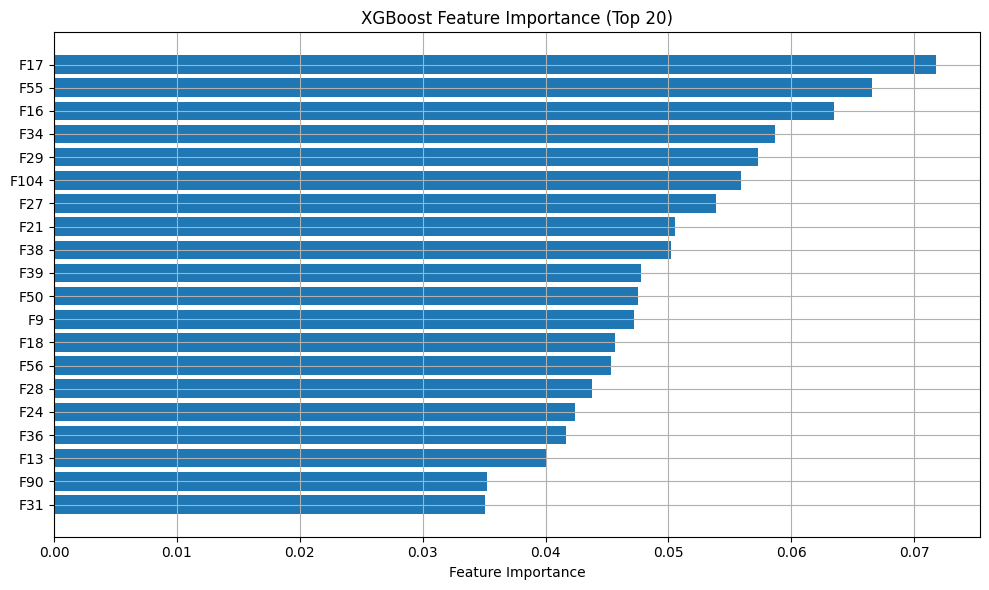

In [4]:
import matplotlib.pyplot as plt

importance = best_model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
plt.barh([top_20_features_xgb[i] for i in sorted_idx], importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance (Top 20)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


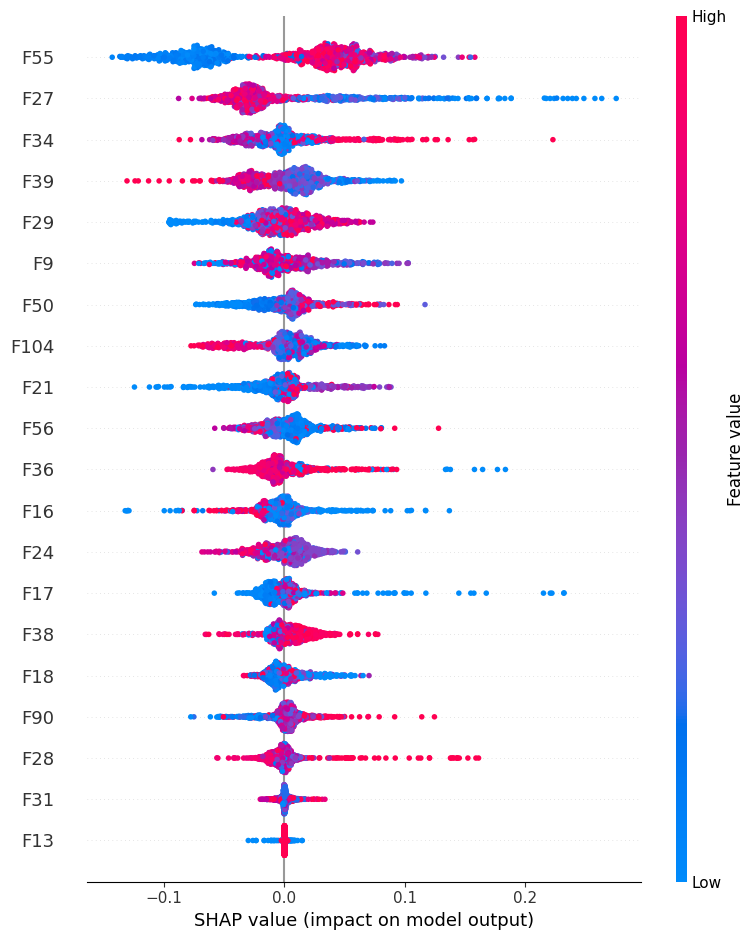

In [5]:
import shap

# Load explainer
explainer = shap.Explainer(best_model)

# Run SHAP on test set
shap_values = explainer(X_test20)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test20, feature_names=top_20_features_xgb)


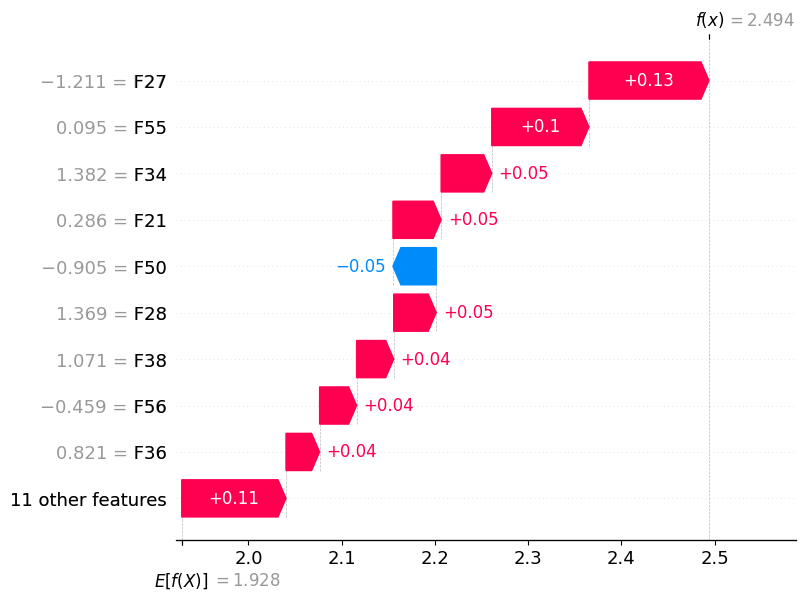

In [6]:
# Rebuild test set with proper column names
import pandas as pd
import shap


X_test_named = pd.DataFrame(X_test20, columns=top_20_features_xgb)

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_named)

i = 5  # sample index i is the row number of data set - 1
shap.plots.waterfall(shap_values[i], max_display=10)


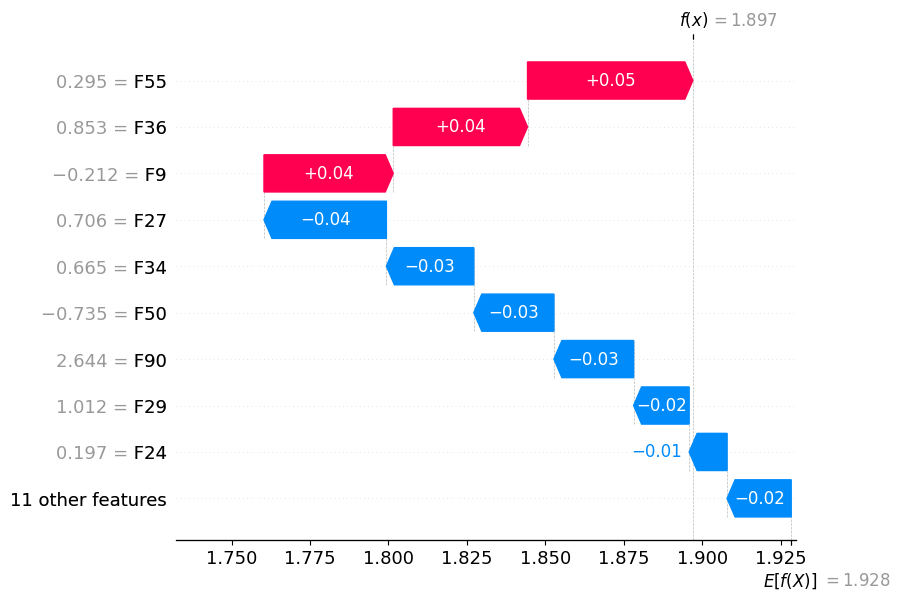

In [7]:
i = 10  # sample index i is the row number of data set - 1
shap.plots.waterfall(shap_values[i], max_display=10)


# Export the model

In [16]:
import joblib

# Example custom directory
output_dir = r"C:\Users\boonk\Documents laptop\URECA Desktop\Data analysis\PlayGround\playground 2.0\Model"

# Save files into the specified folder
joblib.dump(best_model, os.path.join(output_dir, "rugosity_xgb_model.pkl"))
joblib.dump(top_20_features_xgb, os.path.join(output_dir, "rugosity_features.pkl"))
joblib.dump(scaler, os.path.join(output_dir, "rugosity_scaler.pkl"))



['C:\\Users\\boonk\\Documents laptop\\URECA Desktop\\Data analysis\\PlayGround\\playground 2.0\\Model\\rugosity_scaler.pkl']

# Use the model

In [ ]:
import joblib
import pandas as pd

# Load everything
model = joblib.load("rugosity_xgb_model.pkl")
features = joblib.load("rugosity_features.pkl")
scaler = joblib.load("rugosity_scaler.pkl")

# Load new data (example)
new_df = pd.read_excel("new_input_data.xlsx")  # or CSV etc.

# Extract and scale required features
X_new = new_df[features]
X_new_scaled = scaler.transform(X_new)

# Predict
predictions = model.predict(X_new_scaled)

# Append predictions to DataFrame
new_df["Predicted_Rugosity"] = predictions

# Save if needed
new_df.to_excel("predictions_output.xlsx", index=False)


In [10]:

! python --version

Python 3.11.9
